In [1]:
#!git clone https://github.com/HKUDS/VideoRAG.git
from google.colab import drive
drive.mount('/content/drive')

!cp -r /content/drive/MyDrive/KeyBERT-master /content/KeyBERT-master

Mounted at /content/drive


**1. Setup and Data Loading**

**Mount Google Drive and Copy Dataset**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

!cp -r /content/drive/MyDrive/SemEval2017 /content/EvalXtopicTransfer

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Install Required Libraries**

In [3]:
!pip install git+https://github.com/yasamangs/KeyBERT.git

  Cloning https://github.com/yasamangs/KeyBERT.git to /tmp/pip-req-build-0dmuiurq
  Running command git clone --filter=blob:none --quiet https://github.com/yasamangs/KeyBERT.git /tmp/pip-req-build-0dmuiurq
  Resolved https://github.com/yasamangs/KeyBERT.git to commit 29d97ffe55fda7cf9020f895090757279f43ef64
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 72.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 50.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:0

In [4]:
# import sys
# sys.path.append("/content/KeyBERT-master")

In [5]:
!pip install datasets transformers rouge-score sentence-transformers

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=37937b5743067b31bf2469c3c74a97c0415e6d4804e238f4e6d7e76dd82d92ee
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score


In [6]:
!pip install umap-learn

**Import Libraries**

In [7]:

import os
import numpy as np
import pandas as pd
from datasets import Dataset
from transformers import AutoTokenizer, pipeline
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from keybert import KeyBERT
import nltk
from nltk.tokenize import word_tokenize
import re
import torch
from tqdm import tqdm
# C
from sklearn.model_selection import train_test_split, KFold
import random


os.environ["WANDB_DISABLED"] = "true"

# Download NLTK resources
nltk.download('punkt', quiet=True)

True

In [8]:
# Load spaCy and define post-processing functions
import spacy
nlp = spacy.load("en_core_web_sm")

**2. Data Loading and Preprocessing Functions**

**Dataset Loading Function**

In [9]:
# Function to load dataset
def load_kpcrowd_dataset(docs_folder, keys_folder):
    """Load the dataset as raw texts and keyphrases"""
    documents = []
    ground_truth_keywords = []
    filenames = []  # ADDED: Track filenames for proper splitting

    for filename in sorted(os.listdir(docs_folder)):
        if filename.endswith(".txt"):
            # Read document
            doc_path = os.path.join(docs_folder, filename)
            with open(doc_path, 'r', encoding='utf-8') as f:
                document = f.read().strip()
                documents.append(document)

            # Read corresponding keyphrases
            key_filename = filename.replace(".txt", ".key")
            key_path = os.path.join(keys_folder, key_filename)

            with open(key_path, 'r', encoding='utf-8') as f:
                keywords = [kw.strip() for kw in f.read().strip().split('\n') if kw.strip()]
                ground_truth_keywords.append(keywords)

            filenames.append(filename)  # ADDED

    return documents, ground_truth_keywords, filenames

**Train/Validation/Test Split Function**

In [10]:
# Function to create proper train/validation/test splits
def create_train_val_test_split(documents, ground_truth, filenames,
                               train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    """
    Create proper train/validation/test splits to prevent data leakage
    """
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "Ratios must sum to 1"

    # Create indices for splitting
    indices = list(range(len(documents)))

    # First split: train vs (val + test)
    train_indices, temp_indices = train_test_split(
        indices, test_size=(val_ratio + test_ratio), random_state=42, shuffle=True
    )

    # Second split: val vs test
    val_indices, test_indices = train_test_split(
        temp_indices, test_size=test_ratio/(val_ratio + test_ratio), random_state=42, shuffle=True
    )

    # Create splits
    train_docs = [documents[i] for i in train_indices]
    train_gt = [ground_truth[i] for i in train_indices]
    train_files = [filenames[i] for i in train_indices]

    val_docs = [documents[i] for i in val_indices]
    val_gt = [ground_truth[i] for i in val_indices]
    val_files = [filenames[i] for i in val_indices]

    test_docs = [documents[i] for i in test_indices]
    test_gt = [ground_truth[i] for i in test_indices]
    test_files = [filenames[i] for i in test_indices]

    print(f"Dataset split:")
    print(f"  Training: {len(train_docs)} documents ({len(train_docs)/len(documents)*100:.1f}%)")
    print(f"  Validation: {len(val_docs)} documents ({len(val_docs)/len(documents)*100:.1f}%)")
    print(f"  Test: {len(test_docs)} documents ({len(test_docs)/len(documents)*100:.1f}%)")

    return (train_docs, train_gt, train_files), (val_docs, val_gt, val_files), (test_docs, test_gt, test_files)

**post-processing function**

In [11]:
def pos_filter(keywords):
    filtered = []
    for kw, score in keywords:
        doc = nlp(kw)
        if all(token.pos_ in {"NOUN", "PROPN", "ADJ"} for token in doc):
            filtered.append((kw, score))
    return filtered


def advanced_postprocess(keywords, doc_text, nlp):
    keywords = pos_filter(keywords)

    return keywords

**3. Document Processing and Keyword Extraction**

**Document Chunking Function**

In [12]:
# Document chunking function to handle long documents
def chunk_document(doc, max_length=512, overlap=50):
    """Split document into overlapping chunks based on word count"""
    words = doc.split()
    chunks = []

    for i in range(0, len(words), max_length - overlap):
        chunk = ' '.join(words[i:i + max_length])
        chunks.append(chunk)

        if i + max_length >= len(words):
            break

    return chunks

**Optimized Keyword Extraction Function**

In [13]:
# TOPIC MODELING OPTIMIZED KEYWORD EXTRACTION
def extract_keywords_for_topic_modeling(document, model=None, top_n=5):
    """
    Extract keywords optimized for topic modeling using KeyBERT with the specified hyperparameters
    """
    # Initialize KeyBERT with specified model if provided, otherwise use default
    kw_model = model if model else KeyBERT(model="all-MiniLM-L6-v2")

    # Chunk document if it's too long to handle BERT's 512 token limit
    if len(document.split()) > 450:  # Conservative estimate
        chunks = chunk_document(document)
        all_keywords = []

        for chunk in chunks:
            # Extract keywords with the specific hyperparameters mentioned
            # Put the optimized parameters
            keywords = kw_model.extract_keywords(
                chunk,
                keyphrase_ngram_range=(1, 1),
                stop_words='english',
                postprocess=lambda kws: advanced_postprocess(kws, chunk, nlp),
                use_mmr=True,
                nr_candidates= 18,
                diversity=0.4,  # As specified
                top_n=min(top_n + 3, 10)  # Extract a few extra to account for duplicates
            )
            all_keywords.extend(keywords)


        # Combine results from all chunks
        # Sort by score and remove duplicates (keep highest score)
        unique_keywords = {}
        for kw, score in all_keywords:
            if kw not in unique_keywords or score > unique_keywords[kw]:
                unique_keywords[kw] = score

        sorted_keywords = sorted(unique_keywords.items(), key=lambda x: x[1], reverse=True)
        return [kw for kw, _ in sorted_keywords[:top_n]]
    else:
        # For short documents, extract directly
        keywords = kw_model.extract_keywords(
            document,
            keyphrase_ngram_range=(1, 1),
            stop_words='english',
            postprocess=lambda kws: advanced_postprocess(kws, document, nlp),
            use_mmr=True,
            nr_candidates= 18,
            diversity=0.4,  # As specified
            top_n=top_n
        )
        return [kw for kw, _ in keywords]

**4. Model Evaluation Functions**

**KeyBERT Model Evaluation**

In [14]:
def evaluate_keybert_model(documents, ground_truth, model, top_n=5):
    """Evaluate KeyBERT model using semantic-aware precision from the paper"""
    from sentence_transformers import SentenceTransformer
    from sklearn.metrics.pairwise import cosine_similarity
    import numpy as np
    from tqdm import tqdm


    if not isinstance(model, KeyBERT):
        kw_model = KeyBERT(model=model)
    else:
        kw_model = model

    total_precision = 0
    total_recall = 0
    total_f1 = 0

    for doc, gt_keywords in tqdm(zip(documents, ground_truth), total=len(documents)):
        # Extract keywords using KeyBERT
        extracted = kw_model.extract_keywords(
            doc,
            keyphrase_ngram_range=(1, 1),
            stop_words='english',
            postprocess=lambda kws: advanced_postprocess(kws, doc, nlp),
            use_mmr=True,
            diversity=0.4,
            top_n=top_n,
            nr_candidates= 18
        )

        extracted_keywords = [kw[0].lower() for kw in extracted]
        gt_keywords_lower = [kw.lower() for kw in gt_keywords]

        # ---- CHANGES BELOW ---- #
        exact_matches = 0
        partial_matches = 0

        for pred in extracted_keywords:
            pred_words = set(pred.split())
            match_found = False

            for gt in gt_keywords_lower:
                gt_words = set(gt.split())
                if pred == gt:
                    exact_matches += 1
                    match_found = True
                    break
                elif not match_found:
                    overlap = len(pred_words & gt_words) / min(len(pred_words), len(gt_words))
                    if overlap >= 0.5:
                        partial_matches += 1
                        match_found = True
                        break

        matches = exact_matches + partial_matches

        precision = matches / len(extracted_keywords) if extracted_keywords else 0
        recall = matches / len(gt_keywords_lower) if gt_keywords_lower else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

        total_precision += precision
        total_recall += recall
        total_f1 += f1
        # ---- CHANGES END ---- #

    avg_precision = total_precision / len(documents)
    avg_recall = total_recall / len(documents)
    avg_f1 = total_f1 / len(documents)

    return {
        'precision': avg_precision,
        'recall': avg_recall,
        'f1': avg_f1
    }


**Validation Function**

In [15]:
# ADDED: Validation function for model selection
def validate_model(model, val_documents, val_ground_truth, top_n=5):
    """
    Validate the model on validation set for hyperparameter tuning
    """
    results = evaluate_keybert_model(val_documents, val_ground_truth, model, top_n)
    return results['f1']  # Use F1 as validation metric

**5. Topic Modeling Functions**

**Topic Extraction Function**

In [16]:
# Function to get topic clusters from documents
def extract_topics_from_documents(documents, num_topics=5, keywords_per_topic=5, model=None):
    """
    Extract topics from a collection of documents
    This is a simple approach using KeyBERT for topic modeling purposes
    """
    # Create a separate SentenceTransformer model for document encoding
    sentence_model = SentenceTransformer('all-MiniLM-L6-v2')
    # Initialize KeyBERT
    #kw_model = KeyBERT(model="all-MiniLM-L6-v2")
    kw_model = model if model else KeyBERT(model="all-MiniLM-L6-v2")

    # Combined document approach for topic extraction
    all_text = " ".join(documents)

    # Extract more diverse keywords with higher diversity parameter
    topic_keywords = kw_model.extract_keywords(
        all_text,
        keyphrase_ngram_range=(1, 1),
        postprocess=lambda kws: advanced_postprocess(kws, all_text, nlp),
        stop_words='english',
        nr_candidates= 18,
        use_mmr=True,
        diversity=0.7,  # Higher diversity for topics
        top_n=num_topics * keywords_per_topic
    )

    # Get document embeddings
    doc_embeddings = sentence_model.encode(documents)

    # Get embeddings for each keyword
    keyword_embeddings = sentence_model.encode([kw for kw, _ in topic_keywords])

    # For each document, find the most similar keywords
    doc_to_keywords = {}
    for i, doc_embedding in enumerate(doc_embeddings):
        # Calculate similarities
        similarities = cosine_similarity([doc_embedding], keyword_embeddings)[0]

        # Get top keywords for this document
        top_indices = np.argsort(similarities)[-keywords_per_topic:][::-1]
        doc_to_keywords[i] = [(topic_keywords[idx][0], similarities[idx]) for idx in top_indices]

    # Group documents by most similar keyword
    topics = {}
    for doc_idx, keywords in doc_to_keywords.items():
        main_keyword = keywords[0][0]
        if main_keyword not in topics:
            topics[main_keyword] = []
        topics[main_keyword].append(doc_idx)

    # Limit to top N topics
    top_topics = sorted(topics.items(), key=lambda x: len(x[1]), reverse=True)[:num_topics]

    return top_topics, doc_to_keywords

**Topic Visualization Function**

In [17]:
import matplotlib.pyplot as plt
import umap.umap_ as umap

def visualize_topic_clusters(eval_documents, doc_to_keywords, topics, model_name="all-MiniLM-L6-v2"):
    """
    Visualize document-topic clusters using UMAP.
    Each document is colored by its assigned topic.
    """
    print("Generating UMAP visualization of topic clusters...")

    # Load model and encode documents
    sentence_model = SentenceTransformer(model_name)
    doc_embeddings = sentence_model.encode(eval_documents, show_progress_bar=True)

    # Assign topic labels based on main keyword
    doc_labels = [None] * len(eval_documents)
    topic_names = {}
    for i, (topic_keyword, doc_indices) in enumerate(topics):
        topic_names[topic_keyword] = f"Topic {i+1}: {topic_keyword}"
        for idx in doc_indices:
            doc_labels[idx] = topic_keyword

    # Reduce dimensionality using UMAP
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine', random_state=42)
    embedding_2d = reducer.fit_transform(doc_embeddings)

    # Plot
    plt.figure(figsize=(10, 6))
    colors = {}
    for i, label in enumerate(set(filter(None, doc_labels))):
        colors[label] = i

    for i, point in enumerate(embedding_2d):
        label = doc_labels[i]
        if label is not None:
            plt.scatter(point[0], point[1], label=label if label not in colors else "",
                        c=f"C{colors[label]}", s=30, alpha=0.7)

    # Create legend only once
    handles = [plt.Line2D([0], [0], marker='o', color='w', label=topic_names[label],
                          markerfacecolor=f"C{colors[label]}", markersize=8) for label in colors]
    plt.legend(handles=handles, title="Topics", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title("UMAP Projection of Topic Clusters")
    plt.tight_layout()
    plt.show()

**6. Transfer Learning Functions**

**Training Data Preparation**

In [18]:
from sentence_transformers import InputExample, SentenceTransformer, losses, models
import os
import random
from torch.utils.data import DataLoader
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
import re
import numpy as np

# WRAPPER CLASS
class KeyBERTWithPretraining:
    def __init__(self, model: SentenceTransformer):
        self.model = model
        self.kb = KeyBERT(model=model)

    def extract_keywords(self, *args, **kwargs):
        return self.kb.extract_keywords(*args, **kwargs)

    def pre_train(self, fewshot_docs, fewshot_keywords, lr=1e-3, epochs=3):
        train_examples = []
        for doc, keywords in zip(fewshot_docs, fewshot_keywords):
            for kw in keywords:
                train_examples.append(InputExample(texts=[doc, kw], label=1.0))

        train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=8)
        train_loss = losses.CosineSimilarityLoss(self.model)

        self.model.fit(
            train_objectives=[(train_dataloader, train_loss)],
            epochs=epochs,
            warmup_steps=10,
            show_progress_bar=True
        )

    def zeroshot_pre_train(self, seed_keywords, adaptive_thr=0.15):
        self.seed_keyword_embeddings = self.model.encode(seed_keywords, convert_to_tensor=True)
        self.seed_keywords = seed_keywords
        print(f">> Zero-shot pre-training primed with {len(seed_keywords)} seed keywords.")

    def get_model(self):
        return self.model

In [19]:
from sentence_transformers import InputExample, SentenceTransformer, losses, models
import os
import random
from torch.utils.data import DataLoader
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
import re
import numpy as np


def load_semeval_training_pairs(train_documents, train_ground_truth, negatives_per_doc=8, kw_model=None):
    examples = []

    all_documents = train_documents
    all_keyphrases_sets = [set(kw.lower() for kw in keywords) for keywords in train_ground_truth]

    # FEW-SHOT PRE-TRAINING
    fewshot_docs = all_documents[:20]
    fewshot_keywords = train_ground_truth[:20]

    if kw_model is not None and hasattr(kw_model, "pre_train"):
        print(">> Running few-shot pre-training...")
        kw_model.pre_train(fewshot_docs, fewshot_keywords, lr=1e-3, epochs=3)

    # ZERO-SHOT PRE-TRAINING
    if kw_model is not None and hasattr(kw_model, "zeroshot_pre_train"):
        print(">> Running zero-shot keyword pre-training...")
        seed_keywords = [kw for kw, _ in Counter(sum(train_ground_truth, [])).most_common(20)]
        kw_model.zeroshot_pre_train(seed_keywords, adaptive_thr=0.15)

    # Build TF-IDF index for TF-IDF-based negatives
    tfidf = TfidfVectorizer(max_features=5000, ngram_range=(2, 2), stop_words='english')
    tfidf.fit(all_documents)
    feature_names = tfidf.get_feature_names_out()

    # Generate training pairs
    for doc_idx, (document, keyphrases_set) in enumerate(zip(all_documents, all_keyphrases_sets)):
        keyphrases = list(keyphrases_set)

        for kp in keyphrases:
            examples.append(InputExample(texts=[document, kp], label=1.0))

        negatives_added = 0
        target_negatives = min(negatives_per_doc, len(keyphrases) * 2)

        # Strategy 1: n-grams from doc
        words = document.lower().split()
        clean_words = [w for w in words if re.match(r'^[a-zA-Z]+$', w) and len(w) > 2]
        strategy1_count = int(target_negatives * 0.4)

        for _ in range(strategy1_count):
            if len(clean_words) < 3:
                break
            n = random.choice([1, 2, 3, 4])
            if len(clean_words) >= n:
                start = random.randint(0, len(clean_words) - n)
                candidate = " ".join(clean_words[start:start + n])
                if candidate not in keyphrases_set and len(candidate) > 3:
                    examples.append(InputExample(texts=[document, candidate], label=0.0))
                    negatives_added += 1

        # Strategy 2: random GT from other docs
        strategy2_count = int(target_negatives * 0.4)
        other_doc_indices = [i for i in range(len(all_documents)) if i != doc_idx]
        for _ in range(strategy2_count):
            if other_doc_indices:
                other_idx = random.choice(other_doc_indices)
                other_keyphrases = list(all_keyphrases_sets[other_idx])
                if other_keyphrases:
                    candidate = random.choice(other_keyphrases)
                    if candidate not in keyphrases_set:
                        examples.append(InputExample(texts=[document, candidate], label=0.0))
                        negatives_added += 1

        # Strategy 3: low-TFIDF phrases
        strategy3_count = target_negatives - negatives_added
        doc_tfidf = tfidf.transform([document]).toarray()[0]
        low_tfidf_indices = np.argsort(doc_tfidf)[:len(feature_names)//2]

        for _ in range(strategy3_count):
            if len(low_tfidf_indices) > 0:
                idx = random.choice(low_tfidf_indices)
                candidate = feature_names[idx]
                if candidate not in keyphrases_set and len(candidate) > 3:
                    examples.append(InputExample(texts=[document, candidate], label=0.0))

    print(f"Created {len(examples)} training examples")
    return examples


**7. Main Execution Function**

**Complete Transfer Learning Pipeline**

In [20]:
# MAIN FUNCTION - HEAVILY MODIFIED
def TransEvalmain():
    print("Topic Modeling with KeyBERT - Transfer Learning with Proper Train/Val/Test Split")

    # Define paths
    docs_folder = '/content/EvalXtopicTransfer/docsutf8'
    keys_folder = '/content/EvalXtopicTransfer/keys'

    # Load dataset
    print("Loading dataset...")
    documents, ground_truth_keywords, filenames = load_kpcrowd_dataset(docs_folder, keys_folder)
    print(f"Loaded {len(documents)} documents total")

    # ADDED: Create proper train/validation/test splits
    print("\nCreating train/validation/test splits...")
    (train_docs, train_gt, train_files), (val_docs, val_gt, val_files), (test_docs, test_gt, test_files) = create_train_val_test_split(
        documents, ground_truth_keywords, filenames
    )

    # Load base model and prepare for training
    model_name = "sentence-transformers/all-MiniLM-L6-v2"
    word_embedding_model = models.Transformer(model_name)
    pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())
    base_model = SentenceTransformer(modules=[word_embedding_model, pooling_model])
    kw_model = KeyBERTWithPretraining(base_model)

    print(f"\n=== TRANSFER LEARNING ===")
    print("Creating training examples with few-shot and zero-shot pre-training...")
    train_examples = load_semeval_training_pairs(train_docs, train_gt, kw_model=kw_model)

    # Prepare DataLoader
    train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)
    # Contrastive loss
    train_loss = losses.CosineSimilarityLoss(kw_model.model)

    print("Fine-tuning model...")
    best_val_f1 = 0
    best_model_path = "/content/best_fine_tuned_keybert_model"

    # Try different epoch numbers with early stopping
    for epoch in range(1, 4):  # Try 1-3 epochs
        print(f"\nTraining epoch {epoch}...")

        # Fine-tune for one epoch
        kw_model.model.fit(
            train_objectives=[(train_dataloader, train_loss)],
            epochs=1,
            warmup_steps=100,
            show_progress_bar=True
        )

        # Validate
        temp_kw_model = KeyBERT(model=kw_model.model)
        val_f1 = validate_model(temp_kw_model, val_docs, val_gt)
        print(f"Validation F1 after epoch {epoch}: {val_f1:.4f}")

        # Save if best
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            kw_model.model.save(best_model_path)
            print(f"New best model saved! Validation F1: {val_f1:.4f}")
        else:
            print("No improvement, stopping early")
            break

    # Load best model
    print(f"\nLoading best model (Validation F1: {best_val_f1:.4f})")
    fine_tuned_model = KeyBERT(model=best_model_path)

    # MODIFIED: Evaluate on test set (never seen during training/validation)
    print("\n=== FINAL EVALUATION ON TEST SET ===")
    test_results = evaluate_keybert_model(test_docs, test_gt, fine_tuned_model, top_n=5)

    print(f"\nFinal Test Results (Transfer Learning):")
    print(f"  Precision: {test_results['precision']:.4f}")
    print(f"  Recall: {test_results['recall']:.4f}")
    print(f"  F1 Score: {test_results['f1']:.4f}")
    #print(f"  Details: {test_results['details']}")


    # Topic analysis on validation set (not test set)
    print("\n=== TOPIC EXTRACTION EXAMPLE (Validation Set) ===")
    topics, doc_keywords = extract_topics_from_documents(val_docs[:20], num_topics=5, keywords_per_topic=3, model=fine_tuned_model)
    visualize_topic_clusters(val_docs[:20], doc_keywords, topics)

    print("\nIdentified Topics:")
    for i, (topic, doc_indices) in enumerate(topics):
        doc_count = len(doc_indices)
        print(f"Topic {i+1}: '{topic}' - {doc_count} documents")

        if doc_indices:
            sample_idx = doc_indices[0]
            print(f"  Sample document: {val_docs[sample_idx][:100]}...")
            print(f"  Top keywords: {', '.join([kw[0] for kw in doc_keywords[sample_idx][:3]])}")
            print()

    # MODIFIED: Show samples from test set
    print("\n=== SAMPLE EXTRACTIONS FROM TEST SET ===")
    sample_indices = random.sample(range(len(test_docs)), min(3, len(test_docs)))

    for i, idx in enumerate(sample_indices):
        print(f"\n--- Test Sample {i+1} ---")
        doc = test_docs[idx]
        extracted_keywords = extract_keywords_for_topic_modeling(doc, model=fine_tuned_model, top_n=5)
        ground_truth = test_gt[idx]

        print(f"Document preview: {doc[:200]}...")
        print(f"Extracted keywords (top 5): {', '.join(extracted_keywords)}")
        print(f"Ground truth keyphrases: {', '.join(ground_truth)}")

        # Calculate overlap for this sample
        gt_lower = [kw.lower() for kw in ground_truth]
        extracted_lower = [kw.lower() for kw in extracted_keywords]
        overlap = set(extracted_lower) & set(gt_lower)
        print(f"Exact overlap: {list(overlap)} ({len(overlap)}/{len(extracted_keywords)} precision)")

    print("\nEvaluation complete!")

    # ADDED: Return results for further analysis
    return {
        #'baseline': baseline_results,
        'transfer_learning': test_results,
        #'improvement': improvement,
        'best_val_f1': best_val_f1
    }


**8. Run the Complete Pipeline**

**Execute the Main Function**

Topic Modeling with KeyBERT - Transfer Learning with Proper Train/Val/Test Split
Loading dataset...
Loaded 493 documents total

Creating train/validation/test splits...
Dataset split:
  Training: 345 documents (70.0%)
  Validation: 74 documents (15.0%)
  Test: 74 documents (15.0%)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).



=== TRANSFER LEARNING ===
Creating training examples with few-shot and zero-shot pre-training...
>> Running few-shot pre-training...


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss


>> Running zero-shot keyword pre-training...
>> Zero-shot pre-training primed with 20 seed keywords.


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Created 8778 training examples
Fine-tuning model...

Training epoch 1...


Step,Training Loss
500,0.148400


100%|██████████| 74/74 [00:34<00:00,  2.15it/s]


Validation F1 after epoch 1: 0.3317
New best model saved! Validation F1: 0.3317

Training epoch 2...


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Step,Training Loss


Step,Training Loss
500,0.116700


100%|██████████| 74/74 [00:35<00:00,  2.06it/s]


Validation F1 after epoch 2: 0.3185
No improvement, stopping early

Loading best model (Validation F1: 0.3317)

=== FINAL EVALUATION ON TEST SET ===


100%|██████████| 74/74 [00:32<00:00,  2.28it/s]


Final Test Results (Transfer Learning):
  Precision: 0.7374
  Recall: 0.2196
  F1 Score: 0.3244

=== TOPIC EXTRACTION EXAMPLE (Validation Set) ===


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Generating UMAP visualization of topic clusters...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


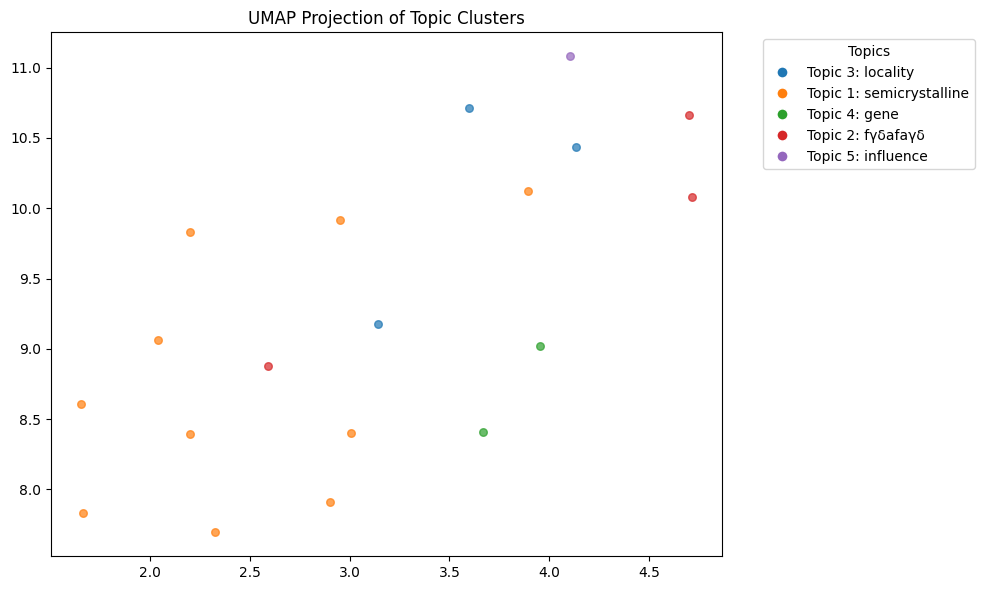


Identified Topics:
Topic 1: 'semicrystalline' - 10 documents
  Sample document: The vapour phase consists of a number of different gases with silicon exhibiting a far higher partia...
  Top keywords: semicrystalline, additive, locality

Topic 2: 'fγδafaγδ' - 3 documents
  Sample document: According to the shortcomings of long time and big errors about the moving plate recognition system,...
  Top keywords: fγδafaγδ, axial, locality

Topic 3: 'locality' - 3 documents
  Sample document: In exploring the WKB limit of quantum theory, Bohm [2] was the first to notice that although one sta...
  Top keywords: locality, fγδafaγδ, gene

Topic 4: 'gene' - 2 documents
  Sample document: Mice bearing the orthotopic model were treated starting from day 21 after NB cell implant; mice with...
  Top keywords: gene, semicrystalline, fγδafaγδ

Topic 5: 'influence' - 1 documents
  Sample document: Although the free Kelvin wave problem is of considerable theoretical importance, problems with forci...
  T

In [21]:

if __name__ == "__main__":
    results = TransEvalmain()

**baseline of semEval2017 test set**

In [27]:
# Evaluate baseline model (without transfer learning)
print("\n=== BASELINE EVALUATION (No Transfer Learning) ===")
# ADDED: Create proper train/validation/test splits
print("\nCreating train/validation/test splits...")
(train_docs, train_gt, train_files), (val_docs, val_gt, val_files), (test_docs, test_gt, test_files) = create_train_val_test_split(
    documents, ground_truth_keywords, filenames
)

baseline_model = KeyBERT(model="all-MiniLM-L6-v2")
baseline_results = evaluate_keybert_model(test_docs, test_gt, baseline_model, top_n=5)
print(f"Baseline Results on Test Set:")
print(f"  Precision: {baseline_results['precision']:.4f}")
print(f"  Recall: {baseline_results['recall']:.4f}")
print(f"  F1 Score: {baseline_results['f1']:.4f}")
#print(f"  Details: {baseline_results['details']}")


=== BASELINE EVALUATION (No Transfer Learning) ===

Creating train/validation/test splits...
Dataset split:
  Training: 350 documents (70.0%)
  Validation: 75 documents (15.0%)
  Test: 75 documents (15.0%)


100%|██████████| 75/75 [00:51<00:00,  1.45it/s]

Baseline Results on Test Set:
  Precision: 0.7184
  Recall: 0.0696
  F1 Score: 0.1233


Cross - adaptation with 500N-KPCrowd-v1.1 dataset

In [22]:
from google.colab import drive
drive.mount('/content/drive')

!cp -r /content/drive/MyDrive/500N-KPCrowd-v1.1 /content/KPCrowd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
def evaluate_keybert_model_kp(documents, ground_truth, model, top_n=5):
    """Evaluate KeyBERT model using semantic-aware precision from the paper"""
    from sentence_transformers import SentenceTransformer
    from sklearn.metrics.pairwise import cosine_similarity
    import numpy as np
    from tqdm import tqdm


    if not isinstance(model, KeyBERT):
        kw_model = KeyBERT(model=model)
    else:
        kw_model = model

    total_precision = 0
    total_recall = 0
    total_f1 = 0

    for doc, gt_keywords in tqdm(zip(documents, ground_truth), total=len(documents)):
        # Extract keywords using KeyBERT
        extracted = kw_model.extract_keywords(
            doc,
            keyphrase_ngram_range=(1, 2),
            stop_words='english',
            postprocess=lambda kws: advanced_postprocess(kws, doc, nlp),
            use_mmr=True,
            diversity=0.4,
            top_n=top_n,
            nr_candidates= 18
        )

        extracted_keywords = [kw[0].lower() for kw in extracted]
        gt_keywords_lower = [kw.lower() for kw in gt_keywords]

        # ---- CHANGES BELOW ---- #
        exact_matches = 0
        partial_matches = 0

        for pred in extracted_keywords:
            pred_words = set(pred.split())
            match_found = False

            for gt in gt_keywords_lower:
                gt_words = set(gt.split())
                if pred == gt:
                    exact_matches += 1
                    match_found = True
                    break
                elif not match_found:
                    overlap = len(pred_words & gt_words) / min(len(pred_words), len(gt_words))
                    if overlap >= 0.5:
                        partial_matches += 1
                        match_found = True
                        break

        matches = exact_matches + partial_matches

        precision = matches / len(extracted_keywords) if extracted_keywords else 0
        recall = matches / len(gt_keywords_lower) if gt_keywords_lower else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

        total_precision += precision
        total_recall += recall
        total_f1 += f1
        # ---- CHANGES END ---- #

    avg_precision = total_precision / len(documents)
    avg_recall = total_recall / len(documents)
    avg_f1 = total_f1 / len(documents)

    return {
        'precision': avg_precision,
        'recall': avg_recall,
        'f1': avg_f1
    }


In [25]:
docs_folder = '/content/KPCrowd/docsutf8'
keys_folder = '/content/KPCrowd/keys'

# Load dataset
print("Loading dataset...")
documents, ground_truth_keywords, filenames = load_kpcrowd_dataset(docs_folder, keys_folder)
print(f"Loaded {len(documents)} documents total")


# Evaluate baseline model (without transfer learning)
print("\n=== BASELINE EVALUATION (No Transfer Learning) ===")
baseline_model = KeyBERT(model="all-MiniLM-L6-v2")
baseline_results = evaluate_keybert_model_kp(documents, ground_truth_keywords, baseline_model, top_n=5)
print(f"Baseline Results on Test Set:")
print(f"  Precision: {baseline_results['precision']:.4f}")
print(f"  Recall: {baseline_results['recall']:.4f}")
print(f"  F1 Score: {baseline_results['f1']:.4f}")



# Evaluate on 500N-KPCrowd-v1.1 dataset
print("\n=== EVALUATION ON 500N-KPCrowd-v1.1 dataset  ===")
best_model_path = "/content/best_fine_tuned_keybert_model"
fine_tuned_model = KeyBERT(model=best_model_path)
results = evaluate_keybert_model_kp(documents, ground_truth_keywords, fine_tuned_model, top_n=5)

print(f"\nFinal Test Results (Transfer Learning):")
print(f"  Precision: {results['precision']:.4f}")
print(f"  Recall: {results['recall']:.4f}")
print(f"  F1 Score: {results['f1']:.4f}")




Loading dataset...
Loaded 500 documents total

=== BASELINE EVALUATION (No Transfer Learning) ===


100%|██████████| 500/500 [11:41<00:00,  1.40s/it]


Baseline Results on Test Set:
  Precision: 0.8467
  Recall: 0.0691
  F1 Score: 0.1233

=== EVALUATION ON 500N-KPCrowd-v1.1 dataset  ===


100%|██████████| 500/500 [12:07<00:00,  1.46s/it]


Final Test Results (Transfer Learning):
  Precision: 0.8233
  Recall: 0.0739
  F1 Score: 0.1315
